In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import mean_squared_error
sns.set(rc={'figure.figsize':(11, 4)})

np.random.seed(0)

read data and keep the data from Dec,31 2012.

In [2]:
# If MONTHLY is true, fit models on monthly data, else fit on daily data.
MONTHLY = True

Energy_Generated  Efficiency  Energy_Exported  Energy_Used  \
Date                                                                     
2020-02-03              3321       3.075             2910            0   
2020-02-04              1611       1.492             1275            0   
2020-02-05              4140       3.833             2816            0   
2020-02-06              4241       3.927             3585            0   
2020-02-07              2654       2.457             2337            0   

            Peak_Power Peak_Time      Condition  Min_Temperature  \
Date                                                               
2020-02-03       646.0     13:40           Fine              6.0   
2020-02-04       678.0     14:30  Mostly Cloudy              8.0   
2020-02-05       737.0     12:40           Fine              0.0   
2020-02-06       740.0     13:00           Fine             -2.0   
2020-02-07       740.0     13:00           Fine              0.0   

            Max_Temperature  Peak_Energy_Import  Off-Peak_Energy_Import  \
Date                                                                      
2020-02-03             29.0                 NaN                     NaN   
2020-02-04             16.0                 NaN                     NaN   
2020-02-05             16.0                 NaN                     NaN   
2020-02-06             20.0                 NaN                     NaN   
2020-02-07             21.0                 NaN                     NaN   

            Shoulder_Energy_Import  High-Shoulder_Energy_Import  Insolation  
Date                                                                         
2020-02-03                     NaN                          NaN        4048  
2020-02-04                     NaN                          NaN        4084  
2020-02-05                     NaN                          NaN        4121  
2020-02-06                     NaN                          NaN        4157  
2020-02-07                     NaN                          NaN        4194

2541


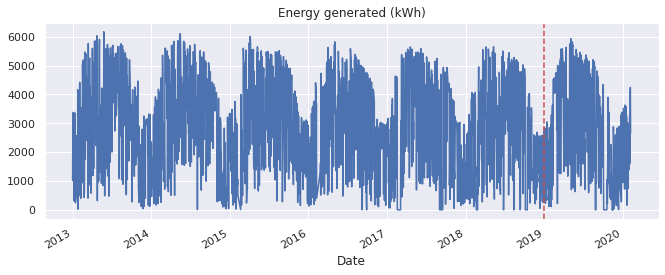

In [3]:
#data = pd.read_pickle("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.pkl")
data = pd.read_csv("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.csv")
data.Date = pd.to_datetime(data['Date'],format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data = data.set_index('Date')

display(data.tail())
print(len(data))


data.Energy_Generated = pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot(title="Energy generated (kWh)")
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
plt.axvline(x=thresh_date, c='r', linestyle='--')

In [4]:
# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

In [5]:
pv_data = data.Energy_Generated.values
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

print(SampEn(pv_data,m=2,r=0.2*np.std(pv_data)))
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

1.6741763844934752
2.0794415416798357
2.2749335616635356


Split data into train and test

In [6]:
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
train_data = data[data.index < thresh_date]
test_data = data[data.index > thresh_date]
display(train_data.head(2))
display(test_data.head(2))

print("Train size %d, test size %d" % (len(train_data), len(test_data)))

Energy_Generated  Efficiency  Energy_Exported  Energy_Used  \
Date                                                                     
2013-01-01              1013       0.938              998            0   
2013-01-02              2878       2.665             2840            0   

            Peak_Power Peak_Time      Condition  Min_Temperature  \
Date                                                               
2013-01-01       807.0     13:10        Showers              8.0   
2013-01-02       837.0     13:00  Mostly Cloudy              7.0   

            Max_Temperature  Peak_Energy_Import  Off-Peak_Energy_Import  \
Date                                                                      
2013-01-01             13.0                 NaN                     NaN   
2013-01-02             13.0                 NaN                     NaN   

            Shoulder_Energy_Import  High-Shoulder_Energy_Import  Insolation  
Date                                                                         
2013-01-01                     NaN                          NaN        3458  
2013-01-02                     NaN                          NaN        3472

Energy_Generated  Efficiency  Energy_Exported  Energy_Used  \
Date                                                                     
2019-01-01              2022       1.872             1637            0   
2019-01-02               277       0.256               88            0   

            Peak_Power Peak_Time Condition  Min_Temperature  Max_Temperature  \
Date                                                                           
2019-01-01       744.0     13:05      Fine             -2.0              9.0   
2019-01-02       116.0     14:40   Showers              2.0              4.0   

            Peak_Energy_Import  Off-Peak_Energy_Import  \
Date                                                     
2019-01-01                 NaN                     NaN   
2019-01-02                 NaN                     NaN   

            Shoulder_Energy_Import  High-Shoulder_Energy_Import  Insolation  
Date                                                                         
2019-01-01                     NaN                          NaN        3243  
2019-01-02                     NaN                          NaN        3255

Train size 2139, test size 401


get daily production from MA with a window of 28 day ; resample the data weekly,monthly

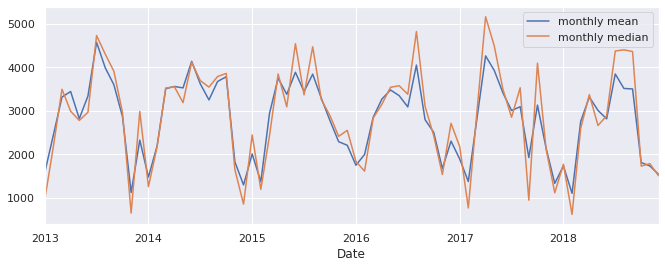

In [7]:
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
monthly_data_median = train_data.Energy_Generated.resample('M').median()
monthly_data_mean.plot(label='monthly mean')
monthly_data_median.plot(label='monthly median')
plt.legend()

weekly_data_mean = train_data.Energy_Generated.resample('W').mean()

0.30308142055145937


Text(0.5, 1.0, 'Trends in Generated Energy')

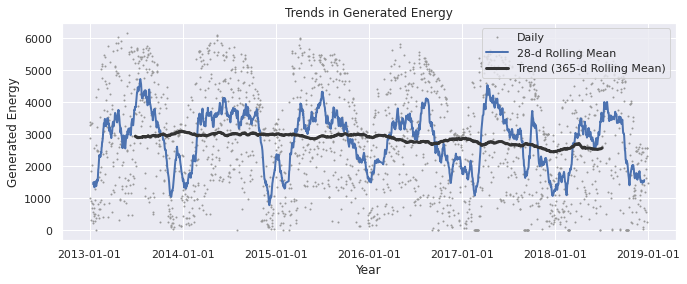

In [8]:
rolling_data_28day = train_data.Energy_Generated.rolling(28, center=True).mean()
print(SampEn(rolling_data_28day,m=2,r=0.2*np.std(rolling_data_28day)))
rolling_data_365day = train_data.Energy_Generated.rolling(window=365, center=True, min_periods=360).mean()
rolling_data_28day = rolling_data_28day.dropna()


# Plot daily, 28-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(train_data.Energy_Generated, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(rolling_data_28day, linewidth=2, label='28-d Rolling Mean')
ax.plot(rolling_data_365day, color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Generated Energy')
ax.set_title('Trends in Generated Energy')

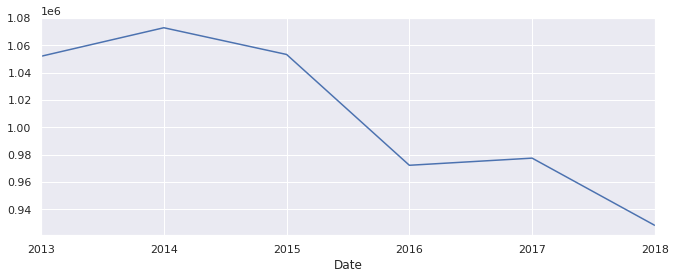

In [9]:
#sns.set(rc={'figure.figsize':(6, 3)})
annual_data_sum = train_data.Energy_Generated.resample('A').sum()
annual_data_sum.plot()

<Figure size 792x288 with 0 Axes>

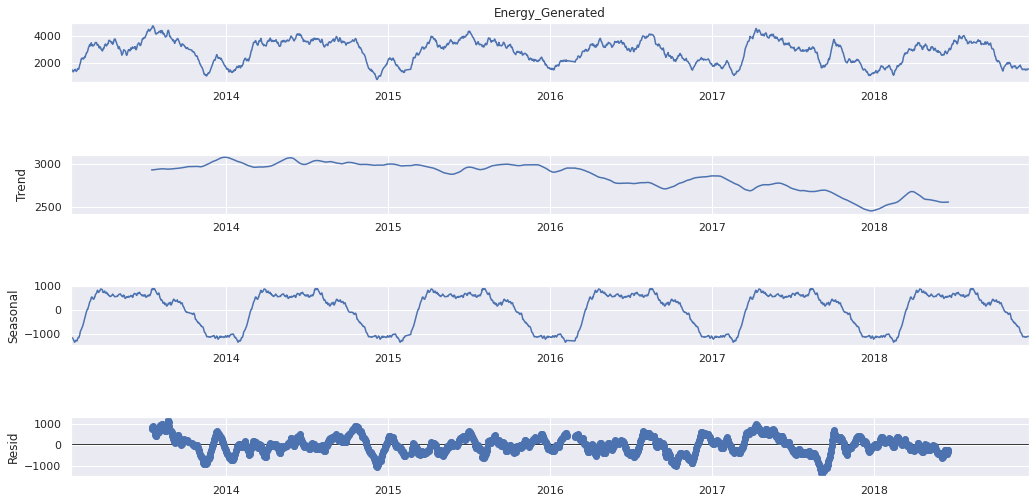

In [10]:
decomposition = seasonal_decompose(rolling_data_28day,period=360) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 792x288 with 0 Axes>

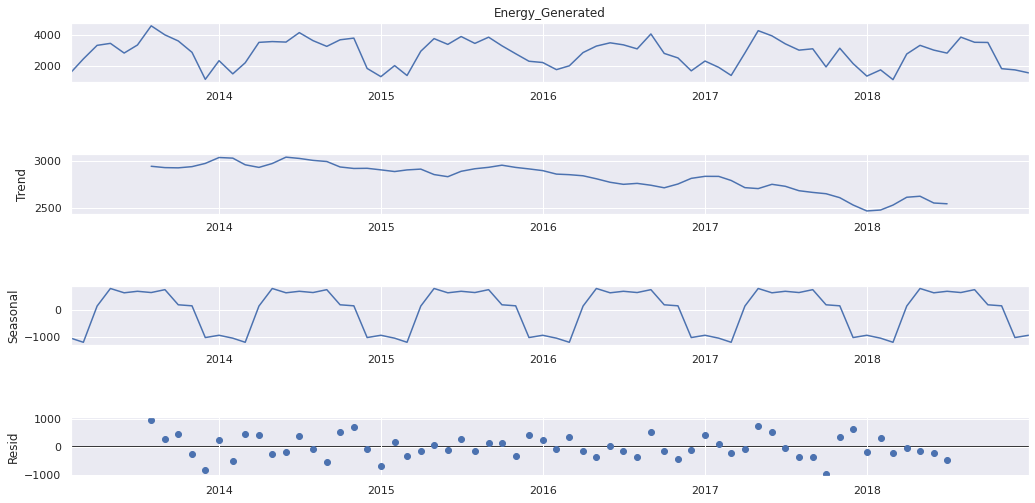

In [11]:
decomposition = seasonal_decompose(monthly_data_mean,period=12) 
fig = plt.figure("Monthly mean seasonal decomposition")  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

<Figure size 792x288 with 0 Axes>

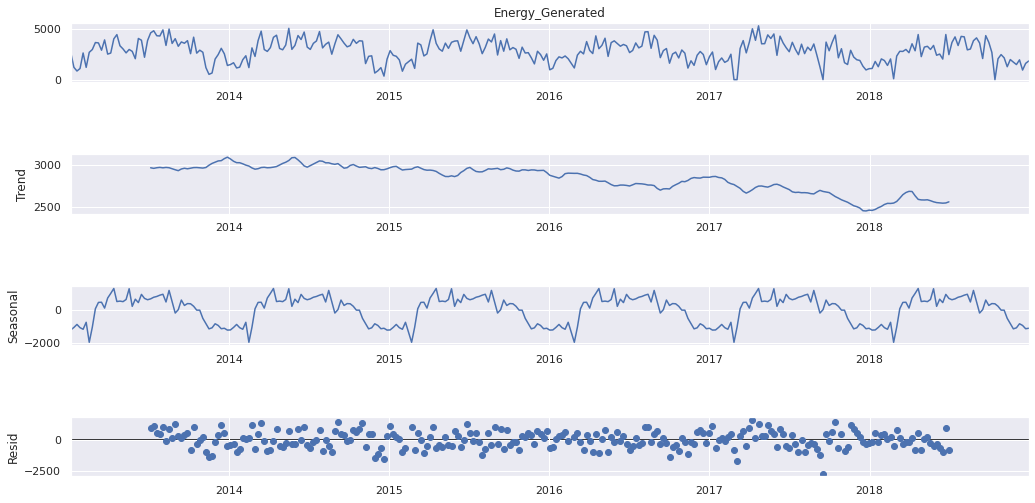

In [12]:
weekly_data_mean = weekly_data_mean.dropna()
decomposition = seasonal_decompose(weekly_data_mean,period=52) 
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## SARIMA 
On weekly mean production and monthly mean production

In [13]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):  
    #Determing rolling statistics
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig  = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

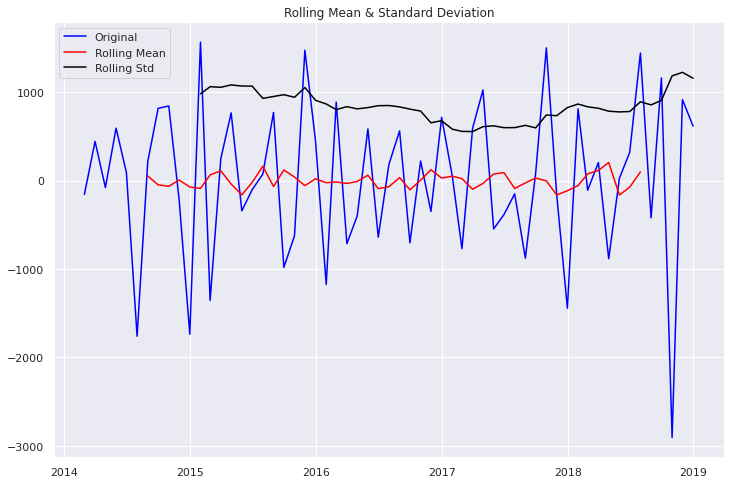

Results of Dickey-Fuller Test:
Test Statistic                -6.572223e+00
p-value                        7.883918e-09
#Lags Used                     4.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [14]:
monthly_data_mean_first_diff = monthly_data_mean - monthly_data_mean.shift(1)  
monthly_data_mean_seasonal_first_difference = monthly_data_mean_first_diff - monthly_data_mean_first_diff.shift(12)
test_stationarity(monthly_data_mean_seasonal_first_difference.dropna(inplace=False))

Autocorrelation study to check the s,p,d,q order

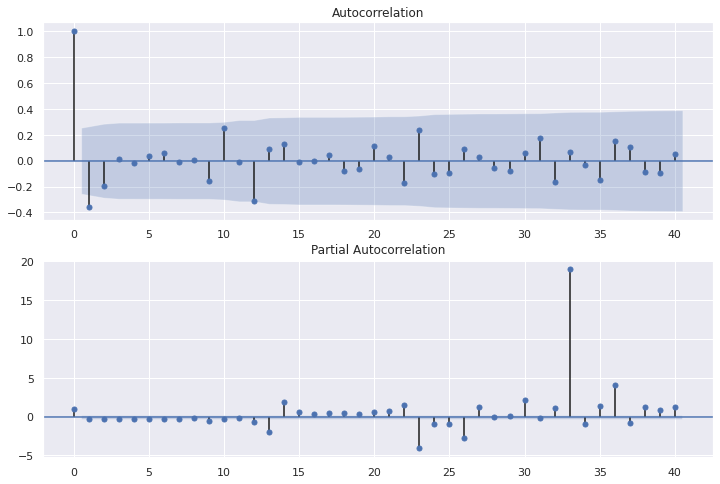

In [15]:
import statsmodels.api as sm 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [16]:
sarima_model = sm.tsa.statespace.SARIMAX(monthly_data_mean, trend='n', order=(0,1,2), seasonal_order=(0,1,2,12))
sarima_results = sarima_model.fit()
print(sarima_results.summary())

SARIMAX Results                                      
Dep. Variable:                   Energy_Generated   No. Observations:                   72
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -455.328
Date:                            Thu, 02 Apr 2020   AIC                            920.657
Time:                                    19:23:31   BIC                            931.044
Sample:                                01-31-2013   HQIC                           924.712
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9909      0.284     -3.494      0.000      -1.547      -0.435
ma.L2         -0.0087      0.143     -0.061      0.951      -0.290      

Residual analysis

count      72.000000
mean      -58.946388
std       670.907798
min     -1946.852573
25%      -533.600962
50%       -16.486492
75%       395.023178
max      1567.161290
dtype: float64


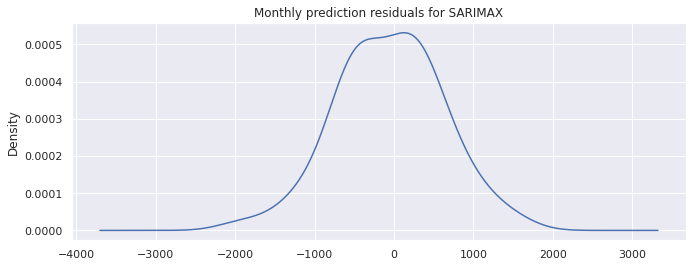

In [17]:
sarima_resid = sarima_results.resid
#residuals.plot()
sarima_resid.plot(kind='kde', title = "Monthly prediction residuals for SARIMAX")
print(sarima_resid.describe())

prediction for monthly data

In [18]:
test_monthly_data_mean = test_data.Energy_Generated.resample('M').mean()
M_test_size = len(test_monthly_data_mean)
print(test_monthly_data_mean)
print(M_test_size)

Date
2019-01-31    1299.166667
2019-02-28    3514.285714
2019-03-31    3820.903226
2019-04-30    3070.866667
2019-05-31    3806.967742
2019-06-30    3884.896552
2019-07-31    3567.774194
2019-08-31    2862.903226
2019-09-30    3067.266667
2019-10-31    1009.129032
2019-11-30    1028.166667
2019-12-31    1710.000000
2020-01-31    2329.193548
2020-02-29    2999.285714
Freq: M, Name: Energy_Generated, dtype: float64
14


SARIMAX out of sample prediction RMSE = 989


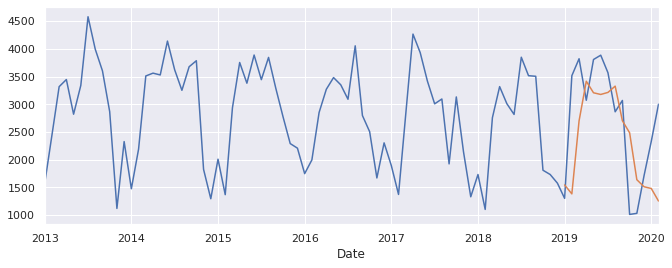

In [19]:
end   = M_test_size + monthly_data_mean.shape[0] - 1
start = monthly_data_mean.shape[0]

forecast_values = sarima_results.predict(start=start, end=end, dynamic=True)

all_monthly_data_mean = data.Energy_Generated.resample('M').mean()
all_monthly_data_mean.plot()
forecast_values.plot()

sa_rmse = mean_squared_error(test_monthly_data_mean.values, forecast_values,squared=False)
print("SARIMAX out of sample prediction RMSE = %d" % sa_rmse) 

## Holt winter

/home/cperier/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/cperier/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/home/cperier/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


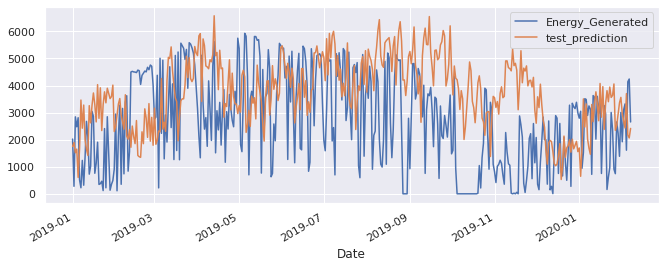

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# fit model
hw_model = ExponentialSmoothing(train_data.Energy_Generated, seasonal='add', seasonal_periods=360,trend='add')
hw_model_fit = hw_model.fit()

#print(model_fit.summary())

# make prediction out-of-sample prediction
yhat = hw_model_fit.predict(start=train_data.shape[0], end=train_data.shape[0] + test_data.shape[0] - 1)
test_data['test_prediction'] = yhat.values
test_data.Energy_Generated.plot(legend=True)
test_data.test_prediction.plot(legend=True)
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error

hw_rmse = mean_squared_error(test_data.Energy_Generated.values, yhat.values,squared=False)
print("Holt Winter raw daily data prediction RMSE = %d" % hw_rmse) 

Holt Winter raw daily data prediction RMSE = 2219


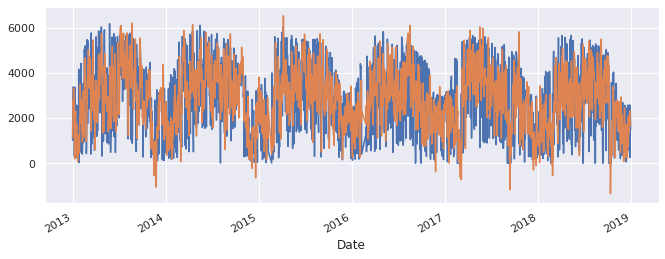

In [22]:
# make prediction in-sample prediction
# TODO mettre dans le bon ordre cette cellule
'''
yhat = model_fit.predict(start=0, end=train_data.shape[0]-1)
raw_data['yhat'] = yhat.values
raw_data.y.plot()
raw_data.yhat.plot()
'''

yhat = hw_model_fit.predict(start=0, end=train_data.shape[0]-1)
train_data['yhat'] = yhat.values
train_data.Energy_Generated.plot()
train_data.yhat.plot()
plt.show()

count    2139.000000
mean        1.493480
std      1397.090003
min     -5341.075957
25%      -902.758444
50%        11.829247
75%       929.981071
max      4092.377423
dtype: float64


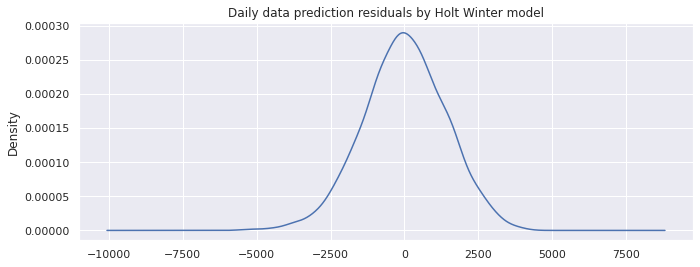

In [23]:
hw_resid = hw_model_fit.resid
hw_resid.plot(kind='kde', title="Daily data prediction residuals by Holt Winter model")
print(hw_resid.describe())

Holt Winter -- statespace format

In [24]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

# fit model
pi_hw_model = ExponentialSmoothing(monthly_data_mean,trend = 'add',seasonal=12)
print(monthly_data_mean.shape)
pi_hw_model_fit = pi_hw_model.fit()
## make prediction
yhat = pi_hw_model_fit.get_prediction()
#data.Energy_Generated.plot()
##print(yhat)
yhat.conf_int()

(72,)
/home/cperier/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


lower Energy_Generated  upper Energy_Generated
Date                                                      
2013-01-31             1350.576594             3082.761183
2013-02-28             1318.566204             3050.750793
2013-03-31             2619.055924             4351.240514
2013-04-30             3083.414941             4815.599530
2013-05-31             2907.975776             4640.160365
...                            ...                     ...
2018-08-31             2236.343539             3968.528128
2018-09-30             2044.842536             3777.027125
2018-10-31             1728.074156             3460.258746
2018-11-30              512.943237             2245.127826
2018-12-31              535.222235             2267.406824

[72 rows x 2 columns]

In [25]:
pi_hw_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:       Energy_Generated   No. Observations:                   72
Model:                   ETS(A, A, A)   Log Likelihood                -540.720
Date:                Thu, 02 Apr 2020   AIC                           1115.441
Time:                        19:23:36   BIC                           1154.144
Sample:                    01-31-2013   HQIC                          1130.848
                         - 12-31-2018   Scale                       195268.490
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.0001      0.084      0.001      0.999      -0.164       0.164
smoothing_trend         0.0001      0.011      0.009      0.993      -0.022       0.022
smoothing_seasonal      0.0022      0.196      0.011      0.991      -0.381       0.385
initial_level        3336.6089    288.909     11.549      0.000    2770.358    3902.860
initial_trend         -12.3554     57.688     -0.214      0.830    -125.421     100.710
initial_seasonal.0  -1013.4389    198.868     -5.096      0.000   -1403.213    -623.665
initial_seasonal.1  -1047.7935    152.677     -6.863      0.000   -1347.034    -748.553
initial_seasonal.2    154.5658    170.369      0.907      0.364    -179.351     488.483
initial_seasonal.3    461.7076    180.407      2.559      0.010     108.116     815.299
initial_seasonal.4    635.9843    227.388      2.797      0.005     190.313    1081.656
initial_seasonal.5    824.2971    175.966      4.684      0.000     479.411    1169.184
initial_seasonal.6    871.4741    197.036      4.423      0.000     485.291    1257.657
initial_seasonal.7    499.6108    185.289      2.696      0.007     136.452     862.770
initial_seasonal.8    662.5373    186.784      3.547      0.000     296.448    1028.627
initial_seasonal.9    185.7496    459.781      0.404      0.686    -715.405    1086.904
initial_seasonal.10 -1127.1097    267.247     -4.217      0.000   -1650.903    -603.316
===================================================================================
Ljung-Box (Q):                       22.25   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.99   Prob(JB):                         0.73
Heteroskedasticity (H):               1.03   Skew:                            -0.18
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Prophet

In [26]:
from fbprophet import Prophet

print(type(monthly_data_mean))
monthly_data_mean = monthly_data_mean.rename({'Date': 'ds','Energy_Generated': 'y'})
weekly_data_mean = weekly_data_mean.rename({'Date': 'ds','Energy_Generated': 'y'})
rolling_data_28day = rolling_data_28day.reset_index()
rolling_data_28day = rolling_data_28day.rename(columns={'Date': 'ds','Energy_Generated': 'y'})
rolling_data_28day = rolling_data_28day.dropna()

raw_data = train_data.reset_index()[['Date','Energy_Generated']]
raw_data = raw_data.rename(columns={'Date': 'ds','Energy_Generated': 'y'})
print(raw_data.tail())
print(raw_data.shape,data.shape,test_data.shape)

model_prophet=Prophet(interval_width=0.95, yearly_seasonality=True)
model_prophet.fit(raw_data)

future_dates = model_prophet.make_future_dataframe(periods=test_data.shape[0],include_history=False)
forecast = model_prophet.predict(future_dates)
print(forecast.shape)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Importing plotly failed. Interactive plots will not work.
<class 'pandas.core.series.Series'>
             ds     y
2134 2018-12-26  2579
2135 2018-12-27  2572
2136 2018-12-28   254
2137 2018-12-29  2314
2138 2018-12-30  1478
(2139, 2) (2541, 14) (401, 15)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(401, 19)


ds         yhat   yhat_lower   yhat_upper
396 2020-01-31  1373.813549 -1582.645573  4182.019496
397 2020-02-01  1251.319699 -1634.043502  4170.355155
398 2020-02-02  1424.732171 -1318.694259  4201.231486
399 2020-02-03  1329.394958 -1677.830250  4260.708629
400 2020-02-04  1288.896348 -1545.722320  4136.962644

In [27]:
#print(test_data.tail())

In [28]:
prophet_rmse = mean_squared_error(test_data.Energy_Generated.values, forecast[['yhat']].values,squared=False)
print("Prophet RMSE = %d" % prophet_rmse) 

Prophet RMSE = 1646


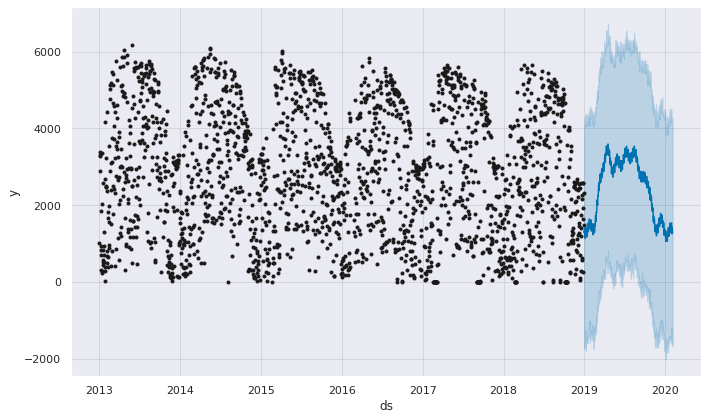

In [29]:
fig = model_prophet.plot(forecast[-len(test_data):],uncertainty=True)
#data.Energy_Generated.plot()

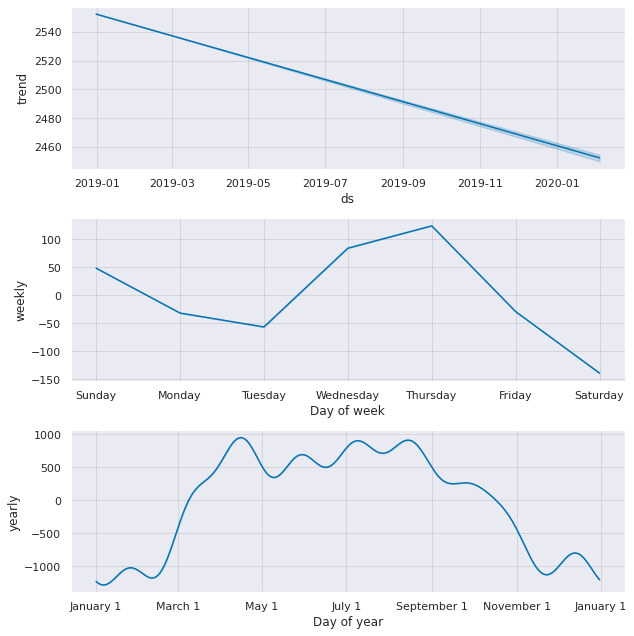

In [30]:
fig = model_prophet.plot_components(forecast)

In [31]:
forecast = model_prophet.predict()
df = pd.merge(raw_data, forecast, on='ds')
prophet_resid = df['yhat'] - df['y']

0.21394562821478164 -3226.5079828197513 3684.3977969226307


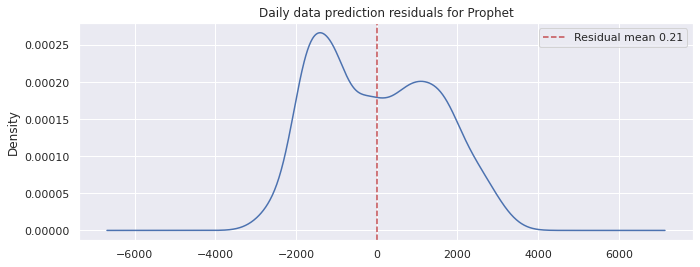

In [32]:
prophet_resid.plot(kind='kde', title = "Daily data prediction residuals for Prophet", label='_nolegend_')
res_mean = np.mean(prophet_resid)
plt.axvline(x=res_mean, c='r', linestyle='--',label="Residual mean {}".format(round(res_mean,2)))
plt.legend()
print(res_mean, np.min(prophet_resid), np.max(prophet_resid))

## LSTM 

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

torch.manual_seed(0)

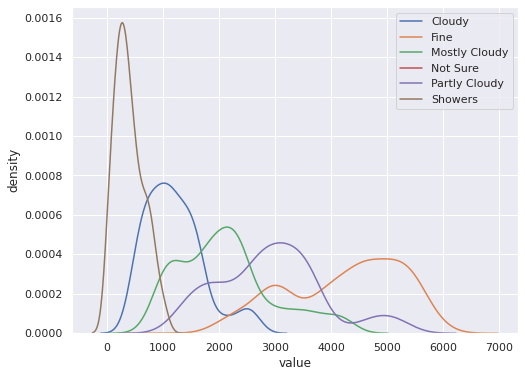

In [34]:
conditions = data.Condition.values
fig, ax = plt.subplots(figsize=(8,6))
for label in np.unique(conditions):
    # this is to plot the kde
    try:
        sns.kdeplot(data.Energy_Generated[data.Condition == label],label=label)
    except:
        print(label)
plt.xlabel('value')
plt.ylabel('density')
plt.show()

In [35]:
features = ['Condition','Energy_Generated']
daily_data_with_weather = data[features]

if('Condition' in features):
    conditions = set(daily_data_with_weather['Condition'])

encoder = LabelEncoder()
daily_data_with_weather.Condition = encoder.fit_transform(daily_data_with_weather.Condition)
conditions_labels = set(daily_data_with_weather['Condition'])

le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)

daily_data_with_weather = daily_data_with_weather[daily_data_with_weather.Condition != 3]

train_size = int(len(daily_data_with_weather) * 0.8)
test_size = len(daily_data_with_weather) - train_size
print(train_size,test_size)

# ensure all data is float
daily_data_with_weather = daily_data_with_weather.astype('float32')
daily_data_with_weather = daily_data_with_weather.dropna()
cols = daily_data_with_weather.columns.tolist()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(daily_data_with_weather.iloc[:train_size])
scaled = scaler.transform(daily_data_with_weather)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(daily_data_with_weather.iloc[:train_size].Energy_Generated.values.reshape(-1,1))

{'Cloudy': 0, 'Fine': 1, 'Mostly Cloudy': 2, 'Not Sure': 3, 'Partly Cloudy': 4, 'Showers': 5}
1976 494


MinMaxScaler(copy=True, feature_range=(0, 1))

In [36]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,n_output=1,bias_init_values=[]):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.n_output = n_output

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, self.n_output)
    
        if bias_init_values :
            for i in range(self.n_output):
                self.l_linear.bias.data[i] = bias_init_values[i]
               


    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [37]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [160]:
n_features = len(features) # this is number of parallel inputs
n_timesteps = 48 # this is number of timesteps

# convert dataset into input/output
X, y = split_sequences(scaled, n_timesteps)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:] 
# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1,weight_decay=0.001)
train_episodes = 200
batch_size = 128

In [161]:
trainX = Variable(torch.Tensor(X_train))
trainY = Variable(torch.Tensor(y_train))

testX = Variable(torch.Tensor(X_test))
testY = Variable(torch.Tensor(y_test))

In [162]:
loss_values = []
val_loss_values = []
for t in range(train_episodes):
    mv_net.train()
    for b in range(0,len(trainX),batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainY[b:b+batch_size]    

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        mv_net.init_hidden(x_batch.size(0))
        output = mv_net(x_batch) 
        loss = criterion(output.view(-1), y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
        
    
    loss_values.append(loss)
        
    ##add test
    mv_net.eval()
    mv_net.init_hidden(testX.size(0))
    test_predict = mv_net(testX)
    loss = criterion(test_predict.view(-1), testY)  
    val_loss_values.append(loss)
    if t % 10 == 0:
        print("%d, loss %f val_loss %f" % (t,loss_values[-1],loss)) 

0, loss 7.778511 val_loss 2.552706
10, loss 0.050882 val_loss 0.058009
20, loss 0.047610 val_loss 0.049371
30, loss 0.040721 val_loss 0.039431
40, loss 0.027216 val_loss 0.025402
50, loss 0.012875 val_loss 0.012631
60, loss 0.004868 val_loss 0.005227
70, loss 0.001708 val_loss 0.002177
80, loss 0.000892 val_loss 0.001039
90, loss 0.000767 val_loss 0.000658
100, loss 0.000418 val_loss 0.001201
110, loss 0.000426 val_loss 0.000446
120, loss 0.000694 val_loss 0.000707
130, loss 0.000170 val_loss 0.000713
140, loss 0.000206 val_loss 0.000329
150, loss 0.001546 val_loss 0.013447
160, loss 0.000113 val_loss 0.000171
170, loss 0.000086 val_loss 0.000138
180, loss 0.000826 val_loss 0.013849
190, loss 0.000073 val_loss 0.000117


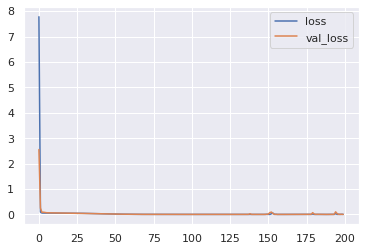

In [163]:
plt.plot(loss_values[:], label="loss")
plt.plot(val_loss_values[:], label="val_loss")
plt.legend()
plt.show()

In [164]:
mv_net.eval()
mv_net.init_hidden(testX.size(0))
test_predict = mv_net(testX).detach().numpy()

test_predict = target_scaler.inverse_transform(test_predict.reshape(-1, 1))

from sklearn.metrics import mean_squared_error
lstm_rmse = mean_squared_error(test_predict[:,0],daily_data_with_weather['Energy_Generated'].iloc[train_size + n_timesteps::1] ,squared=False)
print("RMSE = %d" % lstm_rmse) 

RMSE = 1622


(1976, 1)
(1976,)


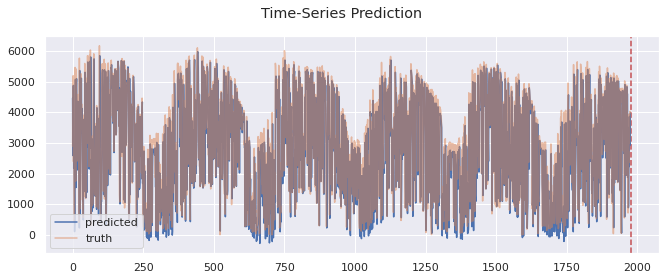

In [186]:
mv_net.init_hidden(trainX.size(0))
train_predict = mv_net(trainX)
train_predict = train_predict.data.numpy()
print(train_predict.shape)

train_truth = daily_data_with_weather['Energy_Generated'].iloc[n_timesteps:train_size + n_timesteps:1]
print(train_truth.shape)
train_predict = target_scaler.inverse_transform(train_predict.reshape(-1,1))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(train_predict[:,0], label="predicted")
plt.plot(train_truth.values[:], alpha=0.5, label="truth")
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

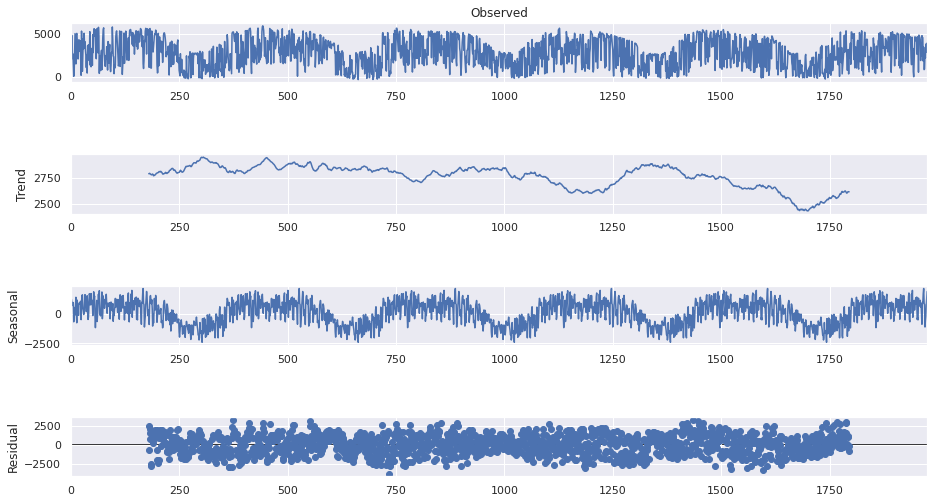

In [166]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train_predict[:,0],period=360) 

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

mean = -146.86845
std  = 1732.0345
-147.01538
0.6987447198677625


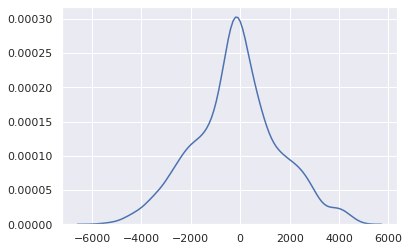

In [167]:
lstm_resid = train_predict[:,0] - train_truth.values
sns.kdeplot(lstm_resid)
print("mean =", np.mean(lstm_resid))
print("std  =", np.std(lstm_resid))
print(np.median(lstm_resid))
from scipy import stats
k2, p  = stats.normaltest(lstm_resid)
print(p)

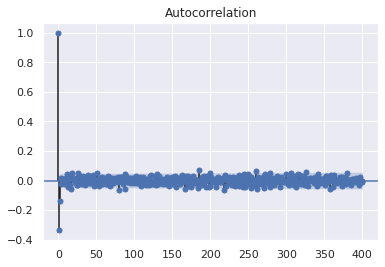

In [168]:
import statsmodels.api as sm
acf = sm.graphics.tsa.plot_acf(lstm_resid, lags=400)

In [233]:
class QdLoss(nn.Module):
    def __init__(self, batch_size, interval=0.90):
        super().__init__()
        self.lambda_ = 0.01 # lambda in loss fn
        self.alpha = 1.- interval # capturing (1-alpha)% of samples
        self.soften = 150.
        self.n = batch_size
        
    def forward(self, preds, y_true):
        self.n = preds.size()[0]
        y_u = preds[:,1]
        y_l = preds[:,0]

        K_HU = torch.clamp(torch.sign(y_u - y_true), min=0.)
        K_HL = torch.clamp(torch.sign(y_true - y_l), min=0.)
        K_H  = torch.mul(K_HU, K_HL)

        K_SU = torch.sigmoid(self.soften * (y_u - y_true))
        K_SL = torch.sigmoid(self.soften * (y_true - y_l))
        K_S  = torch.mul(K_SU, K_SL)

        MPIW_c = torch.sum(torch.mul((y_u - y_l), K_H))/torch.sum(K_H)
        PICP_H = torch.mean(K_H)
        PICP_S = torch.mean(K_S)

        Loss_S = MPIW_c \
                + self.lambda_ * self.n / (self.alpha*(1-self.alpha)) \
                * torch.clamp((1-self.alpha) - PICP_S, min=0.)
        return Loss_S

In [245]:
input_size  = 1
nb_output = 2

bias_init_values = [y.astype(np.float64).min(), y.astype(np.float64).max()]
print(bias_init_values)
pi_mv_net = MV_LSTM(n_features,n_timesteps,nb_output,bias_init_values)
optimizer = torch.optim.Adam(pi_mv_net.parameters(), lr=0.001,weight_decay=0.01)
criterion = QdLoss(batch_size, 0.95)

[0.0, 0.9999999403953552]


In [246]:
pi_loss_values = []
pi_val_loss_values = []

for t in range(2*train_episodes):
    pi_mv_net.train()
    for b in range(0,len(trainX),batch_size):
        inpt = trainX[b:b+batch_size,:,:]
        target = trainY[b:b+batch_size]   

        x_batch = torch.tensor(inpt,dtype=torch.float32)    
        y_batch = torch.tensor(target,dtype=torch.float32)

        pi_mv_net.init_hidden(x_batch.size(0))
        output = pi_mv_net(x_batch) 
        loss = criterion(output, y_batch)  

        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
    pi_loss_values.append(loss)
        
    ##add test
    pi_mv_net.eval()
    pi_mv_net.init_hidden(testX.size(0))
    pi_test_predict = pi_mv_net(testX)
    loss = criterion(pi_test_predict, testY)  
    pi_val_loss_values.append(loss)
    if t % 10 == 0:
        print("%d, loss %f val_loss %f" % (t,pi_loss_values[-1],loss)) 

0, loss 1.120618 val_loss 1.127801
10, loss 0.777455 val_loss 0.780565
20, loss 0.782741 val_loss 0.814458
30, loss 0.851227 val_loss 0.854028
40, loss 0.887556 val_loss 0.871733
50, loss 0.732080 val_loss 0.725069
60, loss 0.730520 val_loss 0.722169
70, loss 0.702309 val_loss 0.699231
80, loss 0.714588 val_loss 0.702283
90, loss 0.648150 val_loss 0.637991
100, loss 0.647144 val_loss 0.617648
110, loss 0.566024 val_loss 0.544458
120, loss 0.666937 val_loss 0.632400
130, loss 0.556150 val_loss 0.540211
140, loss 0.516642 val_loss 0.512274
150, loss 0.548251 val_loss 0.494298
160, loss 0.503259 val_loss 0.748178
170, loss 0.578903 val_loss 0.478704
180, loss 0.479188 val_loss 0.443437
190, loss 0.372067 val_loss 0.459397
200, loss 0.298037 val_loss 0.346164
210, loss 0.465775 val_loss 0.423351
220, loss 0.431946 val_loss 0.465614
230, loss 0.257739 val_loss 0.252612
240, loss 0.323855 val_loss 0.497505
250, loss 0.196156 val_loss 0.322400
260, loss 0.392000 val_loss 0.434390
270, loss 0.

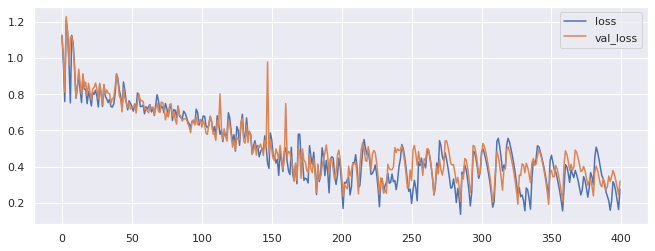

In [247]:
plt.plot(pi_loss_values[:], label="loss")
plt.plot(pi_val_loss_values[:], label="val_loss")
plt.legend()
plt.show()

In [264]:
#pi_mv_net.init_hidden(trainX.size(0))
#pi_predict = pi_mv_net(trainX)
tmp = Variable(torch.Tensor(X))
pi_mv_net.init_hidden(tmp.size(0))
pi_predict = pi_mv_net(tmp)

#### Plot prediction with prediction interval 

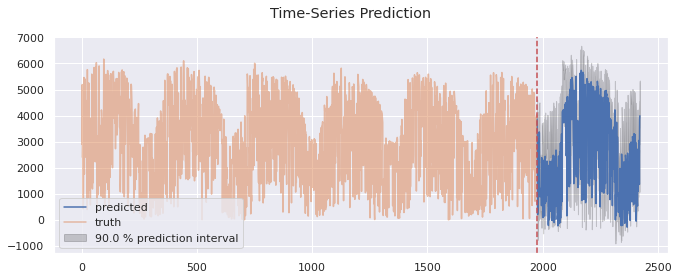

In [265]:
truth = daily_data_with_weather['Energy_Generated']

y_lower, y_upper = pi_predict[:, 0], pi_predict[:, 1]
data_lower = y_lower.data.numpy()
data_upper = y_upper.data.numpy()
data_lower = target_scaler.inverse_transform(data_lower.reshape(-1,1))
data_upper = target_scaler.inverse_transform(data_upper.reshape(-1,1))

pi_predict = pi_predict.data.numpy()


x = np.linspace(len(trainX), len(truth)-n_timesteps, len(testX))
plt.fill_between(x, data_upper[-len(testX):, 0],  data_lower[-len(testX):, 0], color='k', alpha=0.2,  label='{} % prediction interval'.format(100* (1-criterion.alpha)))
#plt.plot(x, data_upper[-len(testX):, 0],c='k')
#plt.plot(x, data_lower[-len(testX):, 0],c='k')
#plt.plot(train_predict[:,0], label="predicted")

x = np.linspace(len(trainX), len(truth)-n_timesteps, len(testX))
plt.plot(x, test_predict[:,0], label="predicted")

plt.plot(truth.values[n_timesteps:train_size+n_timesteps], alpha=0.5, label="truth")

plt.axvline(x=train_size, c='r', linestyle='--')


plt.suptitle('Time-Series Prediction')
plt.legend(loc='lower left')
plt.show()

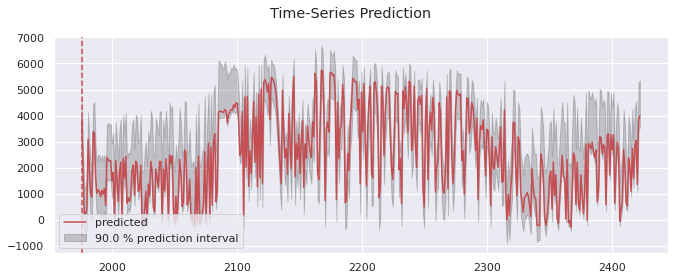

In [266]:
x = np.linspace(len(trainX), len(truth)-n_timesteps, len(testX))
#plt.fill_between(x, data_upper[-len(testX):, 0],  data_lower[-len(testX):, 0], color='k', alpha=0.2,  label='{} % prediction interval'.format(100* (1-criterion.alpha)))
#plt.plot(x, data_upper[-len(testX):, 0],c='k',alpha=0.2)
#plt.plot(x, data_lower[-len(testX):, 0],c='k',alpha=0.2)
plt.plot(x, test_predict[:,0], c='r', label="predicted")
plt.fill_between(x, data_upper[-len(testX):, 0],  data_lower[-len(testX):, 0], color='k', alpha=0.2,  label='{} % prediction interval'.format(100* (1-criterion.alpha)))
plt.axvline(x=train_size, c='r', linestyle='--')


plt.suptitle('Time-Series Prediction')
plt.legend(loc='lower left')
plt.show()

### RESIDUALS and RMSE plots

In [267]:
# Prepare data
lstm_resid = pd.Series(lstm_resid)
residuals = [hw_resid, prophet_resid, lstm_resid]
labels = ['Holt Winter', 'Prophet', 'MV_LSTM']

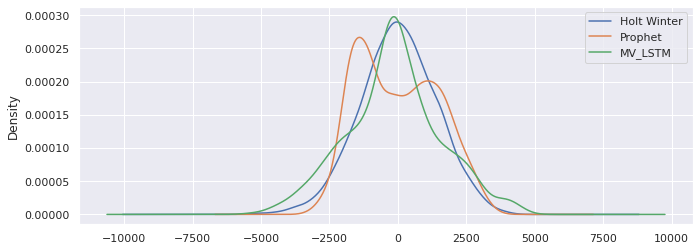

In [268]:
for label, resid in zip(labels,residuals):
    resid.plot(kind='kde', label=label)
plt.legend()
plt.show()

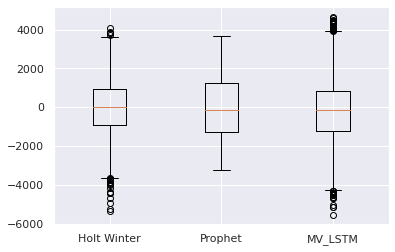

In [269]:
sns.set(rc={'figure.figsize':(6, 4)})
plt.boxplot(residuals, labels = labels)
plt.show()

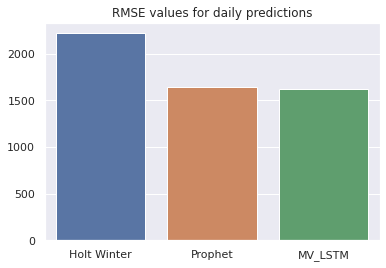

In [270]:
rmse_list = [hw_rmse,prophet_rmse,lstm_rmse]
sns.barplot(labels, rmse_list)
plt.title("RMSE values for daily predictions")
plt.show()

In [271]:
sns.set(rc={'figure.figsize':(11, 4)})